# Quick, Draw GAN

**W tym notebooku użyjemy kodu generatywnej sieci współzawodniczącej (Generative Adversarial Network) zaapożyczonej od [Rowela Atienzy](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py) na licencji [MIT](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/LICENSE), by stworzyć szkice na wzór rysunków stworzonych przez ludzi grających w grę [*Quick, Draw!*](https://quickdraw.withgoogle.com) (dane dostępne [tutaj](https://github.com/googlecreativelab/quickdraw-dataset) na licencji [Creative Commons](https://creativecommons.org/licenses/by/4.0/)).**

#### Zaimportujmy zależności

In [30]:
import numpy as np
import os

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Nadam 

import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#### Załadujmy dane
Bitmapowe pliki Numpy, jak zwykle 28x28 pikseli, dostępne są [tutaj](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap) -- wybierz dowolną kategorię i z pomocą np. biblioteki requests pobierz plik.

In [31]:
import requests

url = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy"
filename = "category.npy"
response = requests.get(url)
with open(filename, "wb") as file:
    file.write(response.content)

In [32]:
input_images = filename

In [33]:
data = np.load(input_images)

In [34]:
data.shape

(134801, 784)

In [35]:
data[2100]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  63,  54,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  31, 243,
       166,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,
       184, 255, 128,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0, 100, 255, 255,  83,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  56, 252, 252, 255,  39,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [36]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1))
img_w,img_h = data.shape[1:3]
data.shape

(134801, 28, 28, 1)

In [37]:
data[2100]

array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        

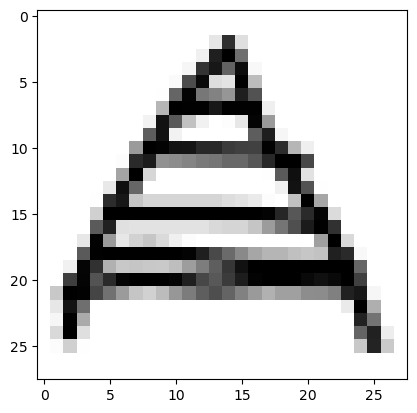

In [38]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

#### Stwórzmy dyskryminator, który będziemy uczyć rozpoznawać obrazy

In [39]:
def build_discriminator(depth=64, p=0.4):

    # definiujemy wejście
    image = Input((img_w,img_h,1))
    
    # tworzymy warstwy konwolucyjne
    conv1 = Conv2D(depth*1, 5, strides=2, padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # warstwa wyjściowa
    prediction = Dense(1, activation='sigmoid')(conv4)
    
    # definicja modelu
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [40]:
discriminator = build_discriminator()

In [41]:
discriminator.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 dropout_5 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)         819456    
                                                                 
 dropout_7 (Dropout)         (None, 4, 4, 256)         0   

In [42]:
discriminator.compile(loss='binary_crossentropy', optimizer=Nadam(lr=0.0008, clipvalue=1.0), metrics=['accuracy'])

#### Stwórzmy sieć generatora, którą będziemy uczyć tworzyć obrazy

In [43]:
z_dimensions = 32

In [44]:
def build_generator(latent_dim=z_dimensions, depth=64, p=0.4):
    
    # zdefiniowanie wejść
    noise = Input((latent_dim,))
    
    # pierwsza warstwa gęsta
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # sieci dekonwolucyjne
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), kernel_size=5, padding='same', activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # warstwa wyjściowa
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # definicja modelu    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [45]:
generator = build_generator()

In [46]:
generator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_3 (Dense)             (None, 3136)              103488    
                                                                 
 batch_normalization_4 (Bat  (None, 3136)              12544     
 chNormalization)                                                
                                                                 
 activation_4 (Activation)   (None, 3136)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 dropout_9 (Dropout)         (None, 7, 7, 64)          0         
                                                           

#### Stwórzmy sieć współzawodniczącą...

In [47]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [48]:
discriminator.trainable = False

In [49]:
pred = discriminator(img)

In [50]:
adversarial_model = Model(z, pred)

In [51]:
adversarial_model.compile(loss='binary_crossentropy', optimizer=Nadam(lr=0.0004, clipvalue=1.0), metrics=['accuracy'])

#### ... i nauczmy ją (w wieeelu epokach)

In [52]:
from tqdm import tqdm

In [53]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in tqdm(range(epochs)):
        
        # pobierzmy prawdziwe obrazy: 
        real_imgs = np.reshape(data[np.random.choice(data.shape[0], batch, replace=False)], (batch,28,28,1))
        
        # wygenerujmy sztuczne obrazy: 
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, z_dim]))
        
        # dodajmy do siebie oba zbiory tworząc w ten sposób wejście dyskrymintora:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # dodajmy etykiety: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # nauczmy dyskryminator: 
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # zaszumione wejście sieci współzawodniczącej oraz "prawdziwe" obrazy: 
        noise = np.random.uniform(-1.0, 1.0, size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # nauczmy sieć współzawodniczącą: 
        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # co jakiś czas printujmy progres i fake'owe obrazy: 
        if (i+1)%20 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

In [ ]:
a_metrics_complete, d_metrics_complete = train()

#### Statystyki

Text(0, 0.5, 'Loss')

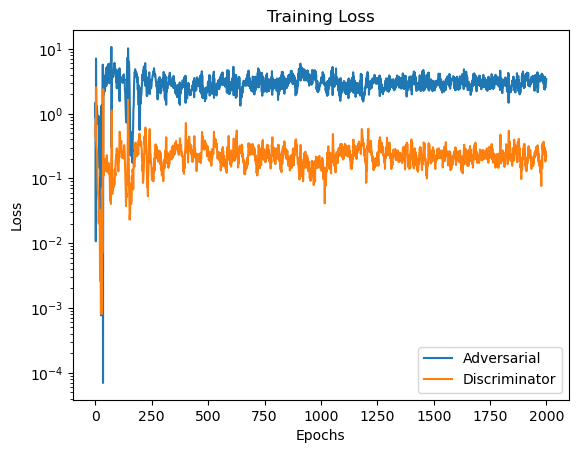

In [55]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

Text(0, 0.5, 'Accuracy')

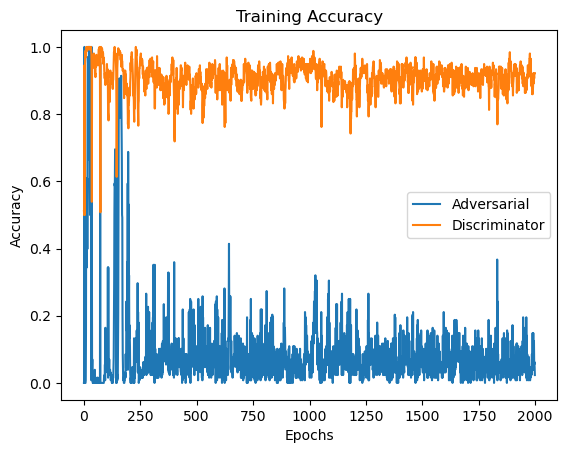

In [56]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")